## 06/08/2024
## Andria Lesane
## Sun Research Group – Weekly Report (5/26 - 6/08)

Summary: Notebook includes functions developed to extract phase diagram data from MPDS. Preliminary code for reproducing phase diagrams using matplotlib.

In [ ]:
#library package used to convert svgpath contained in MPDS JSON files
import sys
!{sys.executable} -m pip install svgpath2mpl

In [71]:
#MPDS API
from mpds_client import MPDSDataRetrieval, MPDSDataTypes, APIError
from mp_api.client import MPRester as New_MPRester
from urllib.parse import urlencode
import httplib2
import json

#Data Visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

#Data Conversion
from IPython.display import HTML, SVG
import numpy as np
from svgpath2mpl import parse_path




c:\Users\andri\anaconda3\envs\matprojenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MPDS_api_key = "hznJUbncUkM6Wt3KkxNdaQIqcGyh62Nzj4leECvWKhxcNRW6"

Below is the function used to query all available phase diagram data that contains the list of specified chemical components. Further development of function will include methods to extract the best binary phase diagram data  with the appropriate solidius boundaries

In [110]:
def get_MPDS_data(components):
    """Retrive MPDS data from cache or API.
    Required: List of components. Must provide only two components if querying binary phase diagrams."""
    client = MPDSDataRetrieval(api_key=MPDS_api_key)
    client.dtype = MPDSDataTypes.PEER_REVIEWED
    sys = '-'.join(sorted(components))
    component_data = {}

    print("\nsearching for phase diagram JSON from MPDS...")
    # phase diagram properties
    # arity - num elements - 2
    # naxes - num axis - 2
    # diatype - phase diagram type - "binary"
    # comp_range - 0-100
    # reference - link to entry
    # shapes - phase boundary info
    # chemical_elements - alphabetized chemcial elements in system
    # temp - temp range of diagram

    sys_fields = {'C': ['chemical_elements', 'entry', 'comp_range', 'temp', 'labels', 'shapes', 'reference']}
    
    diagrams = [d for d in client.get_data(
                search={'elements': sys, 'classes': 'binary'}, fields=sys_fields)if d]
    
    valid_JSON=[]
    
    for d in diagrams:
                    dia_json = {}
                    for i in range(len(sys_fields['C'])):
                        dia_json[sys_fields['C'][i]] = d[i]
                        valid_JSON.append(dia_json)

    return valid_JSON

In [116]:
#Pulling in all available Fe-O system data, obtained via MPDS api
comp=['Fe','O']
data_list=get_MPDS_data(comp)



searching for phase diagram JSON from MPDS...
	50% of step 1 from 1 Got 1735 hits


The function below uses the specified material system to extract solidus curves into matplotlib compatible path and an array of the phase diagram plotting points (a.k.a vertices). Accepts phase diagram data in JSON format. Function uses the same error handling developed for the extract_MPDS_liquidus function.

In [137]:
def extract_MPDS_Solidus(MPDS_json, verbose=True):
    if MPDS_json['reference'] is None:
        if verbose:
            print("system JSON does not contain any data!\n")
        return None

    components = MPDS_json['chemical_elements']
    if verbose:
        print("reading MPDS solidus from entry at " + MPDS_json['reference']['entry'] + "...\n")
    
    # extract solidus curve svgpath from system JSON
    curves = ""
    for boundary in MPDS_json['shapes']:
        if 'label' in boundary and boundary['label'] != 'L':
            curves = curves + boundary['svgpath']
            continue
    if not data:
        if verbose:
            print("no solidus data found in JSON!")
        return None
    
    path = parse_path(curves)

    # convert to coordinates in fractional composition, kelvin
    vertices = [[float(i[0]) / 100.0, float(i[1]) + 273.15] for i in path._vertices]
    return path, vertices


In [138]:
data=data_list[0]
FeOpath, bound_array= extract_MPDS_Solidus(data, verbose=True)

reading MPDS solidus from entry at https://mpds.io/entry/C100150...



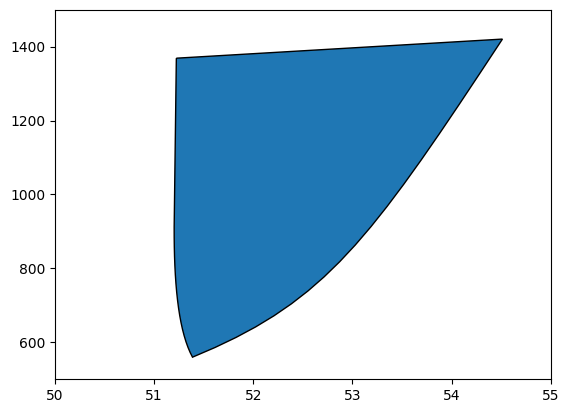

In [139]:
#Using Matplotlib patches to plot Fe-O system diagram

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(FeOpath)
ax.add_patch(patch)
ax.set_ylim(data['temp'][0],data['temp'][1])
ax.set_xlim(data['comp_range'][0],data['comp_range'][1])
plt.show()

To improve data processing function, a few lines of codes will need to be added to filter out duplicate plot lines. In comparison to the PNG version of the phase diagram, MPDS JSON does not include boundary lines for 2-phase solid solution regions.